<a href="https://colab.research.google.com/github/tcapelle/solar_seg/blob/master/Solar_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai
from fastai.vision import *

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.42
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run t

In [3]:
!rm -r solar_seg/
!git clone https://github.com/tcapelle/solar_seg/

rm: cannot remove 'solar_seg/': No such file or directory
Cloning into 'solar_seg'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6194 (delta 1), reused 0 (delta 0), pack-reused 6188
Receiving objects: 100% (6194/6194), 338.96 MiB | 12.50 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Checking out files: 100% (7111/7111), done.


In [0]:
path = Path('solar_seg/')
path_lbl = path/'masks'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('solar_seg/images/02612.png'),
 PosixPath('solar_seg/images/01891.png'),
 PosixPath('solar_seg/images/01616.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('solar_seg/masks/02612.png'),
 PosixPath('solar_seg/masks/01891.png'),
 PosixPath('solar_seg/masks/01616.png')]

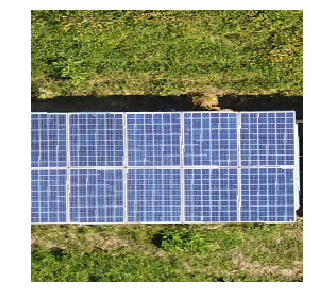

In [12]:
img_f = fnames[580]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [14]:
get_y_fn(img_f)

PosixPath('solar_seg/masks/01781.png')

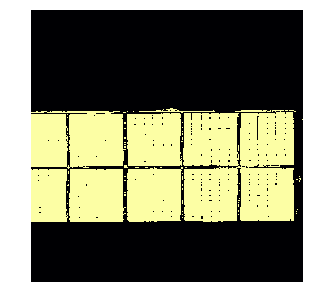

In [15]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(figsize=(5,5), alpha=1, cmap = 'inferno')

In [16]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
size = src_size//2
bs=64

In [0]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)

class MySegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

In [0]:
def get_data(sz, bs):
  src = (MySegmentationItemList.from_folder(path_img)
       .random_split_by_pct(.2)
       .label_from_func(get_y_fn, classes=['background','solar_module']))
  data = (src.transform(get_transforms(flip_vert=True), size=sz, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
  return data

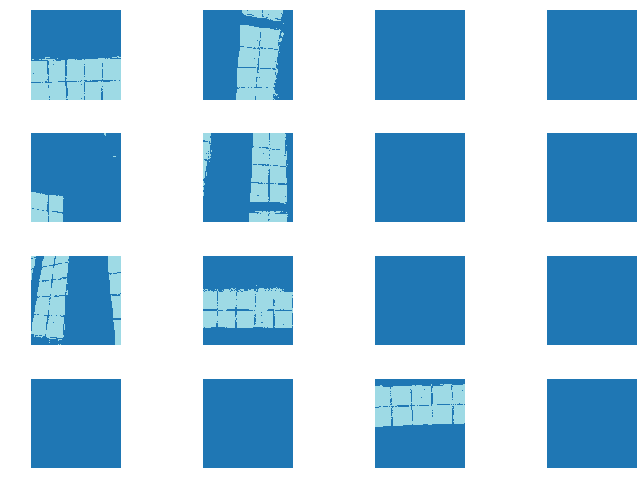

In [25]:
data = get_data(128, 64)
data.show_batch(4, figsize=(10,7), alpha=1)

In [0]:
metrics = partial(dice, iou=True)
wd = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


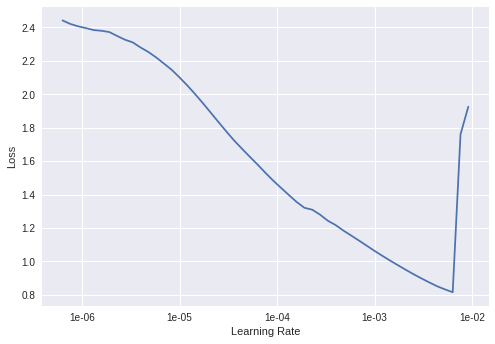

In [23]:
learn.lr_find(); learn.recorder.plot()

In [24]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,dice
1,0.225090,0.053604,0.885553
2,0.093187,0.031187,0.929370
3,0.053108,0.026597,0.936578
4,0.036445,0.024308,0.942009
5,0.028926,0.023191,0.944540
6,0.025721,0.023215,0.944070


In [26]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,dice
1,0.023053,0.023267,0.943619
2,0.023435,0.022367,0.945444
3,0.023026,0.022505,0.944395
4,0.022405,0.021684,0.948957
5,0.021788,0.021271,0.948053
6,0.021591,0.021315,0.947623


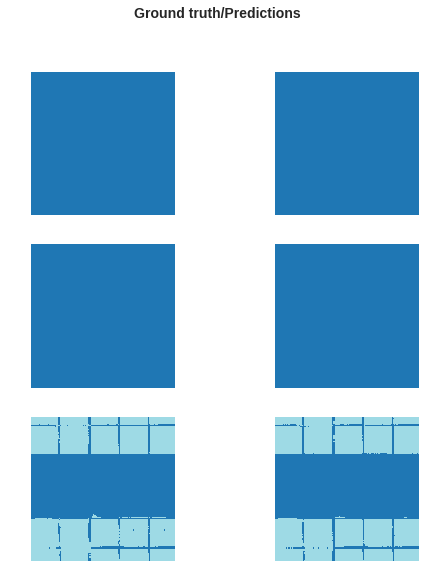

In [27]:
learn.show_results(rows=3, figsize=(8,9), alpha=1)

In [0]:
learn.data = get_data(256, 24)

In [31]:
learn.freeze()
learn.fit_one_cycle(12, 1e-4)

epoch,train_loss,valid_loss,dice
1,0.021569,0.014520,0.962895
2,0.021329,0.014934,0.960542
3,0.021383,0.017071,0.952127
4,0.020752,0.015593,0.957333
5,0.019604,0.013581,0.965391
6,0.019275,0.013914,0.961897
7,0.019609,0.013758,0.962197
8,0.018670,0.012395,0.966525
9,0.017929,0.012191,0.967549
10,0.017223,0.012660,0.965874


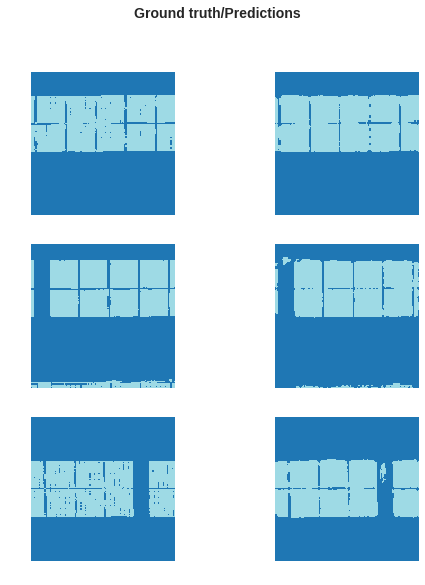

In [0]:
learn.show_results(rows=3, figsize=(8,9), alpha=1)

In [0]:
            asd